# Learning TF with an image classifier

In [28]:
# Check that you have the right dependencies installed!
#!pip list

In [95]:
import tensorflow as tf
import os
import cv2
import imghdr
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [4]:
# LIMIT Memory growth (running this on IGT2 - only 1 GPU available)
gpu_ls = tf.config.experimental.list_physical_devices('GPU') # listing all the gpus available

for g in gpu_ls:
  # print(g)
  tf.config.experimental.set_memory_growth(g, True) # preventing from OOM errors again

Remove bad images:

In [24]:
dir = 'data'
extensions = ['png', 'jpeg', 'jpg', 'bmp'] # dog and cat images downloaded from google --> many extensions

for d in os.listdir(dir):
  path = os.path.join(dir, d)

  # Check the images in each data class, remove the ones that are problematic
  if os.path.isdir(path):
    for ima in os.listdir(path):
      ima_path = os.path.join(path, ima)
      try:
        im = cv2.imread(ima_path)
        if imghdr.what(ima_path) not in extensions:
          print('Image extension not listed. Removing image: {name}'.format(ext=ima_path))
          os.remove(ima_path)
      except Exception as e:
        print('There was an issue with image: {name}. Removing image.'.format(name=ima))
        os.remove(ima_path)
  else:
    continue


In [42]:
#print(len(os.listdir(os.path.join(dir, 'dogs'))))
#print(len(os.listdir(os.path.join(dir, 'cats'))))
# there are 82 imas for dogs and 88 imas for cats after this --> COULD DEFINITELY ADD MORE 
# (let's see how the classification goes -- classes pretty balanced)

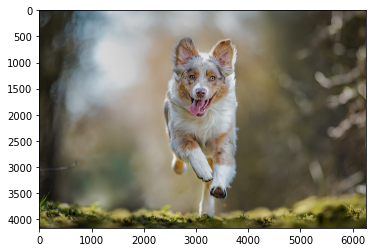

In [27]:
# checking random imas to see if everything is ok
#ima = cv2.imread(ima_path)
#plt.imshow(cv2.cvtColor(ima, cv2.COLOR_BGR2RGB)) 

Load the data (data pipelines):

In [53]:
#help(tf.keras.utils.image_dataset_from_directory)
data = tf.keras.utils.image_dataset_from_directory(dir) 
# batch_size = 32 by default
# im_size = 256 x 256
# NO validation split

# keeping default values for the dataset
data_iterator = data.as_numpy_iterator()
b = data_iterator.next()
b[0].shape 

Found 170 files belonging to 2 classes.


(32, 256, 256, 3)

In [52]:
# DIFFERENCE WITH NORMAL LOADING OF THE DATA:
# data is an object --> GENERATOR --> we can't just access the data by slicing the variable
# instead use an iterator
print(data)
print(data_iterator) # to go though the iterator use the next() method --> next batch
print(len(b)) #batch of data --> b[0] = ima representation, b[1] = labels

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
2


In [54]:
b[1] # 1 == dog, 0 == cat
#ima = b[0][2]
#plt.imshow(ima.astype(int))
#plt.title(b[1][2])

array([1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1], dtype=int32)

Preprocessing

In [63]:
print(b[0].max())
print(b[0].min())

255.0
0.0


In [64]:
# scale ima intensity bt 1 and 0
data = data.map(lambda x,y: (x/255, y)) #x ima, y labels --> same idea as python map
data_iterator = data.as_numpy_iterator()
b = data_iterator.next()
print(b[0].max())
print(b[0].min())

1.0
0.0


In [80]:
# split the data --> size in batches
train_data_size = int(len(data) *0.7) # 70% for training
val_data_size = int(len(data)*0.2) # 20% for training
test_data_size = len(data) - (train_data_size + val_data_size) # 10% for training
# test_data_size and val_data_size are 1 --> add more data (make validation bigger)

training_data = data.take(train_data_size)
validation_data = data.skip(train_data_size).take(val_data_size)
testing_data = data.skip(train_data_size + val_data_size).take(test_data_size)

Model

In [78]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

# Add as many conv blocks as you want
s = [32, 16]
for i in range(2):
  model.add(Conv2D(s[i], (3,3), 1, activation='relu'))
  model.add(MaxPooling2D()) # default 2x2

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # from 0 to 1

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 16)      

In [81]:
log_dir = 'logs'
tensorboard_callbacks = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
history = model.fit(training_data, epochs = 20, validation_data=validation_data, callbacks=[tensorboard_callbacks])


Epoch 1/20
4/4 [==============================] - 19s 4s/step - loss: 1.2722 - accuracy: 0.4375 - val_loss: 0.7210 - val_accuracy: 0.5000
Epoch 2/20
4/4 [==============================] - 18s 3s/step - loss: 0.7056 - accuracy: 0.5000 - val_loss: 0.6935 - val_accuracy: 0.4688
Epoch 3/20
4/4 [==============================] - 17s 4s/step - loss: 0.6774 - accuracy: 0.5469 - val_loss: 0.6484 - val_accuracy: 0.6875
Epoch 4/20
4/4 [==============================] - 22s 5s/step - loss: 0.6491 - accuracy: 0.5938 - val_loss: 0.6403 - val_accuracy: 0.5938
Epoch 5/20
4/4 [==============================] - 22s 5s/step - loss: 0.6338 - accuracy: 0.6250 - val_loss: 0.5551 - val_accuracy: 0.6562
Epoch 6/20
4/4 [==============================] - 22s 5s/step - loss: 0.5929 - accuracy: 0.7109 - val_loss: 0.5609 - val_accuracy: 0.7500
Epoch 7/20
4/4 [==============================] - 22s 5s/step - loss: 0.5506 - accuracy: 0.7344 - val_loss: 0.4306 - val_accuracy: 0.9062
Epoch 8/20
4/4 [==================

In [82]:
history.history

{'loss': [1.2722374200820923,
  0.7055785655975342,
  0.6774028539657593,
  0.6491351127624512,
  0.6338356733322144,
  0.5928980112075806,
  0.5506184101104736,
  0.46855223178863525,
  0.39756637811660767,
  0.38465651869773865,
  0.37806224822998047,
  0.3032509386539459,
  0.20848888158798218,
  0.1742706596851349,
  0.16895774006843567,
  0.09596170485019684,
  0.06778629124164581,
  0.05530797690153122,
  0.037465035915374756,
  0.02410958707332611],
 'accuracy': [0.4375,
  0.5,
  0.546875,
  0.59375,
  0.625,
  0.7109375,
  0.734375,
  0.828125,
  0.8515625,
  0.8125,
  0.84375,
  0.90625,
  0.953125,
  0.9375,
  0.9296875,
  0.9921875,
  0.9921875,
  0.9921875,
  0.9921875,
  1.0],
 'val_loss': [0.7210373878479004,
  0.6934834718704224,
  0.6484236717224121,
  0.640312910079956,
  0.555106520652771,
  0.560861349105835,
  0.4306059181690216,
  0.3666500449180603,
  0.4095957279205322,
  0.3956402838230133,
  0.4163925349712372,
  0.2157100886106491,
  0.21464397013187408,
  0.2

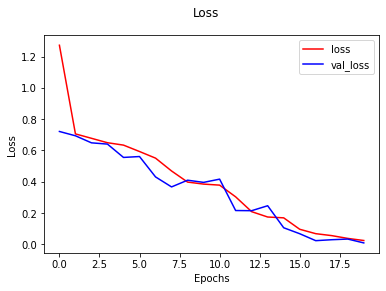

In [88]:
# plot the results for loss
fig = plt.figure()
plt.plot(history.history['loss'], color='red', label='loss')
plt.plot(history.history['val_loss'], color='blue', label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
fig.suptitle('Loss')
plt.legend(loc='upper right')
plt.show()


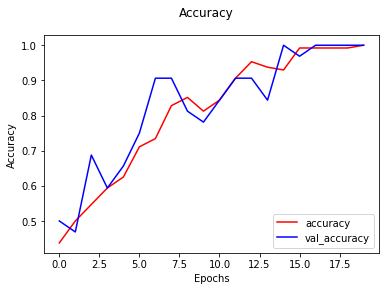

In [92]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='red', label='accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
fig.suptitle('Accuracy')
plt.legend(loc='lower right')
plt.show()


In [89]:
# This very easy network seems to work pretty well for the images used (I was
# actually expecting overfitting with the accuracy reaching 1)
# let's check with the testing data

In [102]:
# Evaluation metrics
precision = Precision()
recall = Recall() 
binaryAcc = BinaryAccuracy()
metrics = [precision, recall, binaryAcc]

In [114]:
# THERE'S ONLY ONE BATCH --> this could be a loop if I hadn't only used 1
b = testing_data.as_numpy_iterator().next()
X_test = b[0]
y_test = b[1]
y_pred = model.predict(X_test)

# evaluate
for m in metrics:
  m.update_state(y_test, y_pred)
  name = str(m).split('(')[0]
  print(name, m.result().numpy())

1/1 [==============================] - 0s 161ms/step
Precision 1.0
Recall 1.0
BinaryAccuracy 1.0


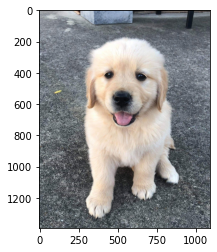

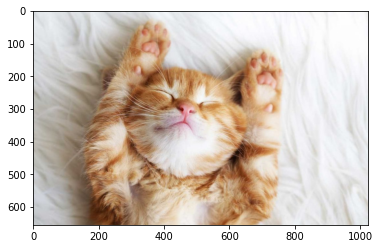

In [119]:
test_ima_1 = 'test_ima_1.jpeg' # dog
test_ima_2 = 'test_ima_2.jpeg' # cat
imas = [test_ima_1, test_ima_2]

for ima in imas:
  im = cv2.imread(ima)
  plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
  plt.show()

In [129]:
im1 = tf.image.resize(cv2.imread(test_ima_1), (256,256))
im2 = tf.image.resize(cv2.imread(test_ima_2), (256,256))

imas = [im1, im2]

#for ima in imas:
#  ima = ima.numpy().astype(int)
#  plt.imshow(ima)
#  plt.show()

In [130]:
predictions = []
for ima in imas:
  exp = np.expand_dims(ima/255, 0) # model requires a batch
  predictions.append(model.predict(exp)) 

1/1 [==============================] - 0s 43ms/step


In [132]:
for p in predictions:
  if p > 0.5:
    print('Prediction is: dog')
  else:
    print('Prediction is: cat')


Prediction is: dog
Prediction is: cat


In [133]:
model.save(os.path.join('models', 'cat_dog_classifier_tf.h5'))